# Landsat 8 USGS L2A Salinity Example

### This Notebook is still under devleopment. Currently it shows options for possible salinity indexes. 

## Initialise

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

dc = datacube.Datacube(app='salinity-example')
print('done')

done


## Set up datacube query

In [2]:
query = {}
query['product'] = 'ls8_usgs_sr_scene'  # for this example we will load some data from Landsat 8
query['output_crs'] = 'EPSG:3460'  # let's output our data in the Fiji projection
query['group_by'] = 'solar_day'  # datasets can often overlap, we will combine all data that occurs on the same day

## Define Time of Interest

In [3]:
# Time does not need to be set, if you want to do a full time search (NOT recommended!)
# You can specifcy a specific day:
# query['time'] = '2011-10-15'
# or can be expressed as a range:
# query['time'] = ('2011-11-14','2011-11-16')
# time can be formatted as either '20111015' or '2011-10-15'
query['time'] = ('2019-01-13', '2019-01-15')

## Define Area of Interest


In [4]:
# Similar to to time, a spatial area of interest does not need to be set (NOT recommended!)
# You can specify a specific Sentinel 2 MGRS location using region code:
# query['region_code']='089079'
# alternatively you can create a bounding box, to do this you need three parameters:
#query['x'] = (177.9998, 179.0434)
#query['y'] = (-19.0809, -18.0857)
query['x'] = (178.2819, 178.6019)
query['y'] = (-18.2316, -18.0516)
#query['crs'] = 'EPSG:3460'

## Load and Visualise Area of interest

In [5]:
full_resolution = dc.load(
    resolution = (-30, 30), # this is the 'native' or 'full' resolution of Landsat data
    measurements=['red','green','blue','pixel_qa','nir','swir1','swir2'], # for this example we will also retrieve the 'pixel_qa' band
    **query #use the query we defined above
)

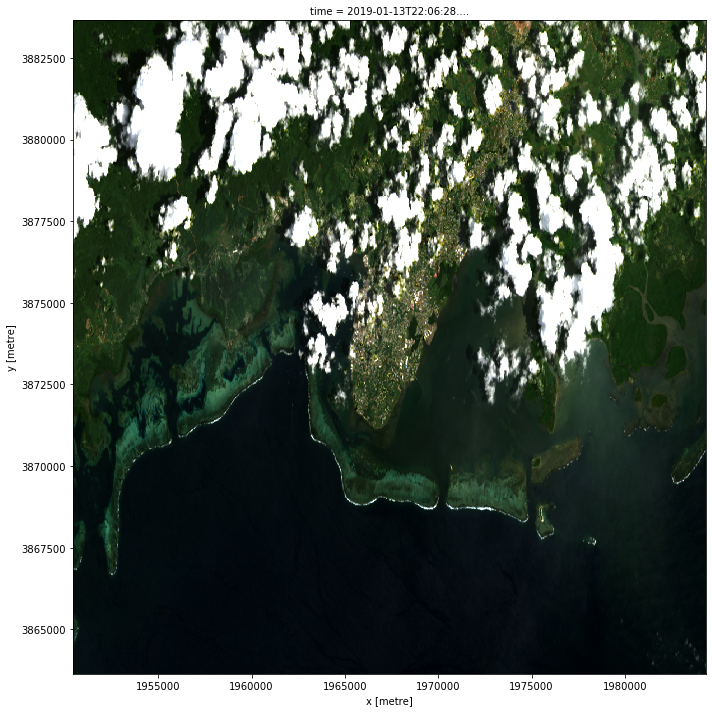

In [6]:
# Plot as cloudy RGB image
full_resolution[['red','green','blue']].to_array().plot.imshow(
    col='time',
    figsize=(10, 10),
    vmin=0,
    vmax=3000
);

In [7]:
# Identify pixels with valid data:
good_quality = (
    (full_resolution.pixel_qa == 322)  | # clear
    (full_resolution.pixel_qa == 386)  |
    (full_resolution.pixel_qa == 834)  |
    (full_resolution.pixel_qa == 898)  |
    (full_resolution.pixel_qa == 1346) 

)

In [8]:
# Apply mask
full_resolution = full_resolution.where(good_quality)

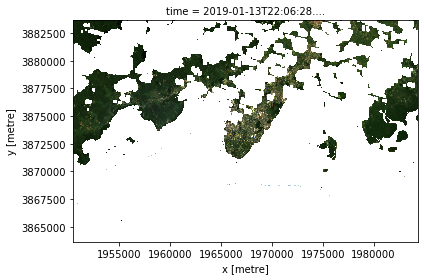

In [9]:
# Plot as cloud free RGB image
full_resolution[['red','green','blue']].to_array().plot.imshow(
    col='time',
    figsize=(6, 4),
    vmin=0,
    vmax=3000
);

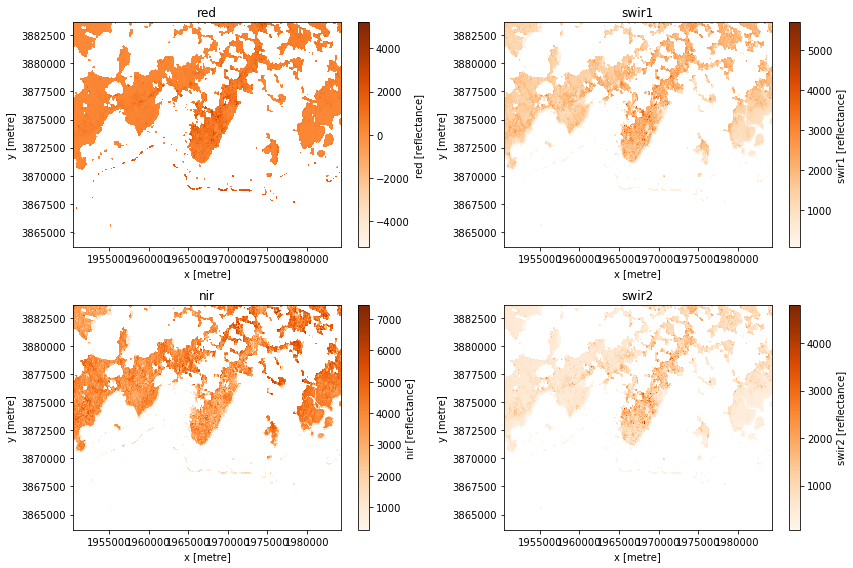

In [10]:
#plot the fractional cover bands. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
full_resolution.red.isel(time=scene).plot(cmap='Oranges')
ax1.set_title('red')

ax2=plt.subplot(gs[1,0])
full_resolution.nir.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('nir')

ax3=plt.subplot(gs[0,1])
full_resolution.swir1.isel(time=scene).plot(cmap='Oranges')
ax3.set_title('swir1')

ax4=plt.subplot(gs[1,1])
full_resolution.swir2.isel(time=scene).plot(cmap='Oranges')
ax4.set_title('swir2')

plt.tight_layout()
plt.show()

In [11]:
swir1 = full_resolution['swir1']
swir2 = full_resolution['swir2']
nir = full_resolution['nir']
red = full_resolution['red']
nir = full_resolution['nir']
green = full_resolution['green']

## NSI Index

From this paper - based in UAE - arid environment. 
https://www.sciencedirect.com/science/article/pii/S2352938518303069

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/xarray/core/computation.py:565: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


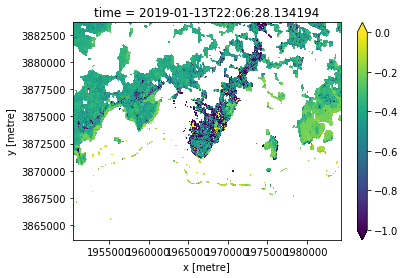

In [12]:
NSI = np.divide((swir1-swir2), (swir1-nir))
NSI.isel(time=0).plot(figsize = (6, 4), vmin = -1, vmax = 0)

## NDSI - Normalised Difference Salinity Index

Also from https://www.sciencedirect.com/science/article/pii/S2352938518303069

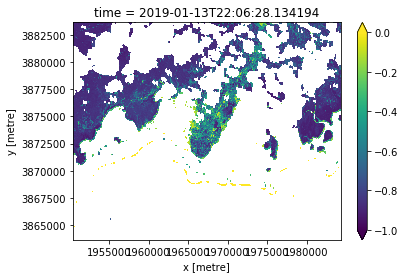

In [13]:
NDSI = np.divide((red-nir), (red+nir))
NDSI.isel(time=0).plot(figsize = (6, 4), vmin = -1, vmax = 0)

## SSSI1
Also from https://www.sciencedirect.com/science/article/pii/S2352938518303069

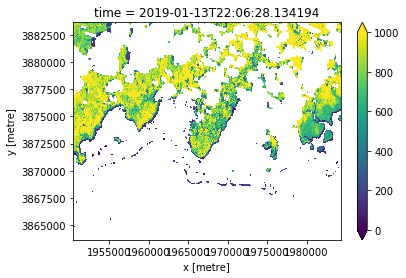

In [14]:
SSSI1 = np.subtract(swir1, swir2)
SSSI1.isel(time=0).plot(figsize = (6, 4), vmin = -1, vmax = 1000)

## SSSI2
Also from https://www.sciencedirect.com/science/article/pii/S2352938518303069.

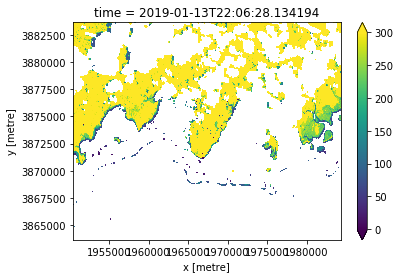

In [15]:
SSSI2 = np.divide(((swir1*swir2 - swir2*swir2)),swir1)
SSSI2.isel(time=0).plot(figsize = (6, 4), vmin = -1, vmax = 300)

## SIASTER
Also from https://www.sciencedirect.com/science/article/pii/S2352938518303069.

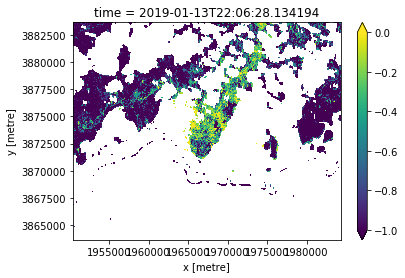

In [16]:
SIASTER = np.divide((swir1- nir), (swir1 + swir2))
SIASTER.isel(time=0).plot(figsize = (6, 4), vmin = -1, vmax = 0)

## SI - Salinity Index
From https://www.sciencedirect.com/science/article/pii/S1658077X16300042 - in agricultural region in Ethiopia.
Although for L5 - unsure how well bands transate - maybe missing out on the use of SWIR. 

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/xarray/core/computation.py:565: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


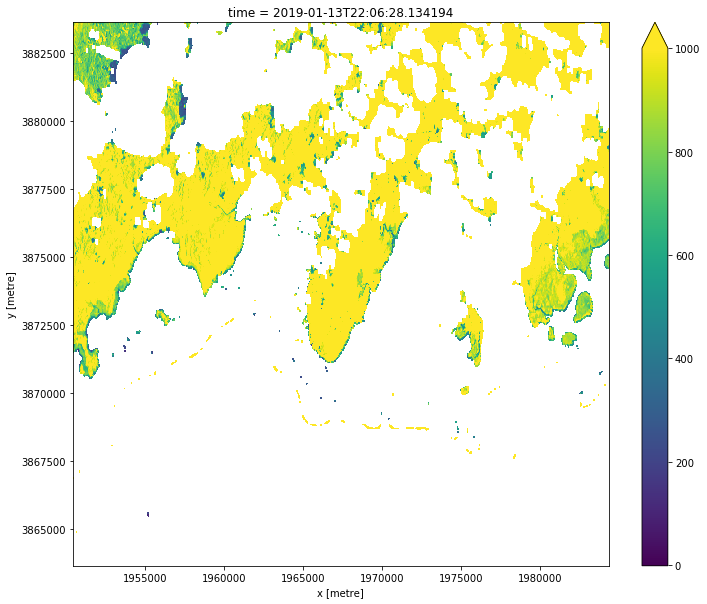

In [17]:
SI = np.sqrt(red*nir)
SI.isel(time=0).plot(figsize = (12, 10), vmin = -1, vmax = 1000)

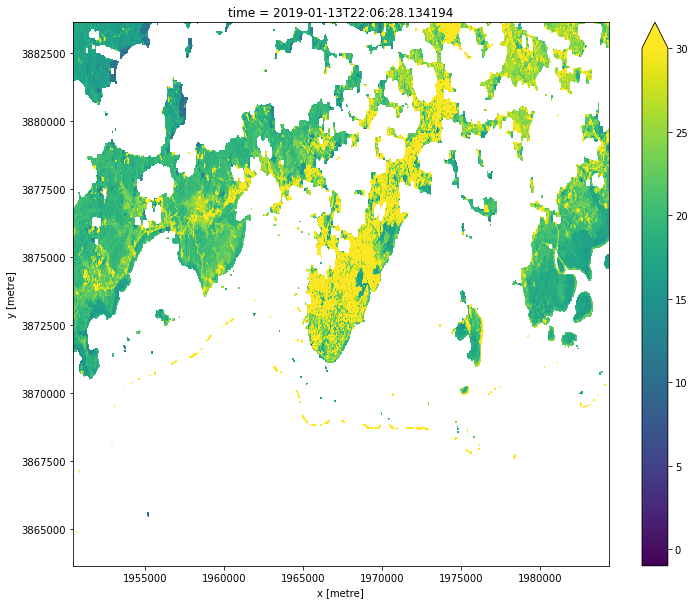

In [18]:
#tried with green and red bands as unsure how well this translates
SI2a = np.sqrt(green*red)
SI2b = np.sqrt(SI2a)
SI2b.isel(time=0).plot(figsize = (12, 10), vmin = -1, vmax = 30)